In [1]:
import os
import dmd
import matplotlib.pyplot as plt
import numpy as np
import timeit
from scipy.linalg import pinv
from scipy.stats import linregress
from scipy.integrate import solve_ivp
colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

In [2]:
filebase0='data/1ddmd/'
verbose=True

T=20
dt=0.05
def f(t,x):
    return -np.sin(x)**3
def f2(t,x):
    return -np.sin(x)

numtraj=5

evs=[]
ev2s=[]
bss=[]
bs2s=[]
dmin=500
dmax=2000
dd=500
ds=np.arange(dmin,dmax+1,dd)

for num in ds:
    print(num)
    X=np.zeros((numtraj,int(T/dt)-1,num+1))
    Xtraj=np.zeros((numtraj,int(T/dt)-1))
    Y=np.zeros((numtraj,int(T/dt)-1,num+1))
    X2=np.zeros((numtraj,int(T/dt)-1,num+1))
    X2traj=np.zeros((numtraj,int(T/dt)-1))
    Y2=np.zeros((numtraj,int(T/dt)-1,num+1))
    ics=np.flip(np.pi/2*np.arange(1,numtraj+1)/(numtraj))
    # ics=[3*np.pi/4]

    
    library_funcs=[lambda x: np.ones(x.shape)]+[lambda x, n=n: np.cos(n*x) for n in range(1,num//2+1)]+[lambda x, n=n: np.sin(n*x) for n in range(1,num//2+1)]
    for i in range(numtraj):
        sol=solve_ivp(f,[0,T],[ics[i]],t_eval=np.arange(int(T/dt))*dt,rtol=1E-12,atol=1E-12)
        sol2=solve_ivp(f2,[0,T],[ics[i]],t_eval=np.arange(int(T/dt))*dt,rtol=1E-12,atol=1E-12)
        t=sol.t
        y=sol.y
        y2=sol2.y
        X[i]=np.array([func(y[0][:-1]) for func in library_funcs]).T
        Xtraj[i]=y[0][:-1]
        Y[i]=np.array([func(y[0][1:]) for func in library_funcs]).T
        
        X2[i]=np.array([func(y2[0][:-1]) for func in library_funcs]).T
        X2traj[i]=y2[0][:-1]
        Y2[i]=np.array([func(y2[0][1:]) for func in library_funcs]).T
    
    X=np.concatenate(X,axis=0)
    Y=np.concatenate(Y,axis=0)
    X2=np.concatenate(X2,axis=0)
    Y2=np.concatenate(Y2,axis=0)
    np.save(filebase0+'Xtraj.npy',Xtraj)
    np.save(filebase0+'X2traj.npy',X2traj)
    filebase=filebase0+'algebraic_%i'%(num)
    
    
    s,u,v,errs=dmd.PCA(X,filebase,verbose,save=False)
    print(s.shape,u.shape,v.shape)
    try:
        r=np.where(s<s.max() * max(X.shape[0],X.shape[1]) * np.finfo(X.dtype).eps)[0][0]
    except:
        r=len(s)
    evals,evecs,res,phis,bs=dmd.resDMD(u[:,:r],v[:r,:],s[:r],X,Y,filebase,verbose,save=True)
    
    filebase=filebase0+'exponential_%i'%(num)
    s2,u2,v2,errs2=dmd.PCA(X2,filebase0,verbose,save=False)
    try:
        r2=np.where(s2<s2.max() * max(X2.shape[0],X2.shape[1]) * np.finfo(X2.dtype).eps)[0][0]
    except:
        r2=len(s2)
    evals2,evecs2,res2,phis2,bs2=dmd.resDMD(u2[:,:r2],v2[:r2,:],s2[:r2],X2,Y2,filebase,verbose,save=True)

    
    ev2s=ev2s+[evals2[np.where(res2<1E-6)[0]]]
    bs2s=bs2s+[bs2[:,np.where(res2<1E-6)[0]]]
    evs=evs+[evals[np.where(res<1E-6)[0]]]
    bss=bss+[bs[:,np.where(res<1E-6)[0]]]

500
svd runtime: 0.09875302901491523
full rank: 112
(501,) (1995, 1995) (501, 501)
Ktilde shape: (112, 112)
eig runtime: 0.00556611199863255
residue runtime: 0.005023101111873984
svd runtime: 0.06909399013966322
full rank: 116
Ktilde shape: (116, 116)
eig runtime: 0.00781305693089962
residue runtime: 0.004813204053789377
1000
svd runtime: 0.18489314895123243
full rank: 173
(1001,) (1995, 1995) (1001, 1001)
Ktilde shape: (173, 173)
eig runtime: 0.025570700177922845
residue runtime: 0.007078632013872266
svd runtime: 0.1641503651626408
full rank: 168
Ktilde shape: (168, 168)
eig runtime: 0.026853793999180198
residue runtime: 0.006787808844819665
1500
svd runtime: 0.36786736198700964
full rank: 221
(1501,) (1995, 1995) (1501, 1501)
Ktilde shape: (221, 221)
eig runtime: 0.03730527497828007
residue runtime: 0.011654202127829194
svd runtime: 0.3150171188171953
full rank: 202
Ktilde shape: (202, 202)
eig runtime: 0.03722931398078799
residue runtime: 0.00912922015413642
2000
svd runtime: 0.6364

In [3]:
num=2000
nr=51
ni=51
murs=-5+6*np.arange(nr)/(nr-1)
muis=-5+2*5*np.arange(ni)/(ni-1)

filebase=filebase0+'algebraic_%i'%(num)
inds=np.intersect1d(np.where(np.abs(np.real(np.log(evals)/dt))<5)[0],np.where(np.abs(np.imag(np.log(evals)/dt))<5)[0])
zs=np.concatenate([np.exp((murs[:,np.newaxis]+1j*muis[np.newaxis,:]).ravel()*dt),evals[inds]])
zs,pseudo,xis,its=dmd.resDMDpseudo(u[:,:r],v[:r,:],s[:r],X,Y,zs,evals,evecs,filebase,verbose,save=True)

filebase=filebase0+'exponential_%i'%(num)
inds2=np.intersect1d(np.where(np.abs(np.real(np.log(evals2)/dt))<5)[0],np.where(np.abs(np.imag(np.log(evals2)/dt))<5)[0])
zs2=np.concatenate([np.exp((murs[:,np.newaxis]+1j*muis[np.newaxis,:]).ravel()*dt),evals2[inds2]])
zs2,pseudo2,xis2,its2=dmd.resDMDpseudo(u2[:,:r2],v2[:r2,:],s2[:r2],X2,Y2,zs2,evals2,evecs2,filebase,verbose,save=True)

0.999622	0.977033	0.0000005
pseudospectra runtime: 85.42339135101065
0.999618	0.781786	-0.199349
pseudospectra runtime: 61.024416530970484


In [80]:
filebase0='data/1ddmd/'

evs=[]
bss=[]
for i in range(len(ds)):
    filebase=filebase0+'algebraic_%i'%ds[i]
    evals=np.load(filebase+'evals.npy')
    res=np.load(filebase+'res.npy')
    bs=np.load(filebase+'bs.npy')
    evs=evs+[evals[np.where(res<1E-6)[0]]]
    bss=bss+[bs[:,np.where(res<1E-6)[0]]]
zs=np.load(filebase+'zs.npy')
pseudo=np.load(filebase+'pseudo.npy')

ev2s=[]
bs2s=[]
for i in range(len(ds)):
    filebase=filebase0+'exponential_%i'%ds[i]
    evals2=np.load(filebase+'evals.npy')
    res2=np.load(filebase+'res.npy')
    bs2=np.load(filebase+'bs.npy')
    ev2s=ev2s+[evals2[np.where(res2<1E-6)[0]]]
    bs2s=bs2s+[bs2[:,np.where(res2<1E-6)[0]]]
zs2=np.load(filebase+'zs.npy')
pseudo2=np.load(filebase+'pseudo.npy')

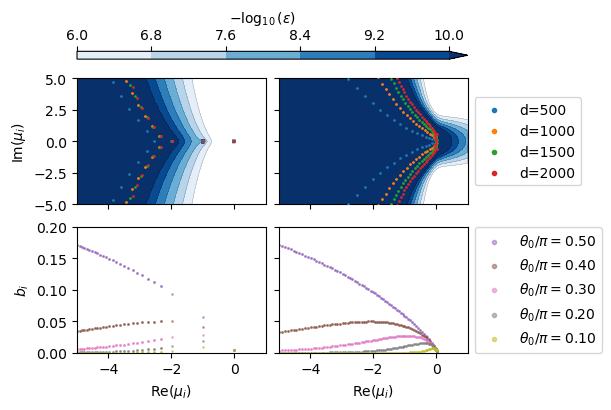

In [88]:
resmin=1E-6
resmax=1E-10
levels=-np.log(resmin)/np.log(10)+(-np.log(resmax)/np.log(10)+np.log(resmin)/np.log(10))*np.arange(6)/5
markers=['>','v','^','<','o']
fig,axs=plt.subplots(2,2,figsize=(6,4),layout='constrained')

plt.subplot(2,2,1)
for i in range(len(ev2s)):
    plt.scatter(np.real(np.log(ev2s[i])/dt),np.imag(np.log(ev2s[i])/dt),s=1,label='d=%i'%ds[i],zorder=4)
plt.xlim(-5,1)
plt.ylim(-5,5)
# plt.title('$\dot{\phi}=-\sin(\theta)$')
plt.gca().set_xticklabels('')
plt.ylabel('$\mathrm{Im}(\mu_i)$')

cs1 = plt.gca().tricontourf(np.real(np.log(zs2)/dt),np.imag(np.log(zs2)/dt),np.log(1/np.array(pseudo2))/np.log(10),levels=levels,cmap='Blues',extend='max')
cs2 = plt.gca().tricontour(cs1,levels=levels,colors=('k',),linewidths=0.1)


plt.subplot(2,2,2)
for i in range(len(evs)):
    plt.scatter(np.real(np.log(evs[i])/dt),np.imag(np.log(evs[i])/dt),s=1,label='d=%i'%ds[i],zorder=4)
# plt.title('$\dot{\phi}=-\sin(\theta)^3$')
plt.xlim(-5,1)
plt.ylim(-5,5)
plt.gca().set_xticklabels('')
plt.gca().set_yticklabels('')
cs1 = plt.gca().tricontourf(np.real(np.log(zs)/dt),np.imag(np.log(zs)/dt),np.log(1/np.array(pseudo))/np.log(10),levels=levels,cmap='Blues',extend='max')
cs2 = plt.gca().tricontour(cs1,levels=levels,colors=('k',),linewidths=0.1)
fig.colorbar(cs1, ax=axs[:,:], location='top',aspect=50,label=r'$-\log_{10}(\varepsilon)$')

plt.gca().legend(loc='center left', markerscale=3, bbox_to_anchor=(1, 0.5))

plt.subplot(2,2,3)
# for i in range(len(ev2s)):
for i in [len(ev2s)-1]:
    # for j in range(numtraj//2):
    for j in range(numtraj):
        plt.scatter(np.real(np.log(ev2s[i])/dt),np.abs(bs2s[i][j*int(T/dt-1)]),s=1,alpha=0.5,c=colors[j+4])
plt.xlim(-5,1)
plt.ylim(0,0.2)
plt.xlabel('$\mathrm{Re}(\mu_i)$')
plt.ylabel('$b_i$')

plt.subplot(2,2,4)
# for i in range(len(evs)):
for i in [len(evs)-1]:
    # for j in range(numtraj//2):
    for j in range(numtraj):
        if i==len(evs)-1:
            plt.scatter(np.real(np.log(evs[i])/dt),np.abs(bss[i][j*int(T/dt-1)]),s=1,alpha=0.5,c=colors[j+4],label=r'$\theta_0/\pi=%.2f$'%(ics[j]/np.pi))
        else:
            plt.scatter(np.real(np.log(evs[i])/dt),np.abs(bss[i][j*int(T/dt-1)]),s=1,alpha=0.5,c=colors[j+4])     
            
plt.xlim(-5,1)
plt.ylim(0,0.2)
plt.gca().legend(loc='center left', markerscale=3, bbox_to_anchor=(1, 0.5))
plt.xlabel('$\mathrm{Re}(\mu_i)$')
plt.gca().set_yticklabels('')


plt.savefig('1ddmd1.pdf')
plt.show()

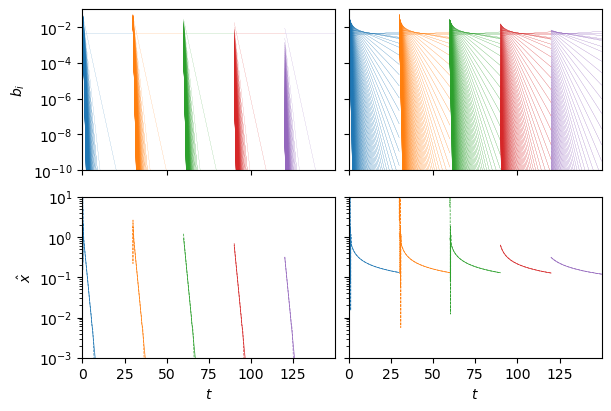

In [89]:
i=len(ds)-1
filebase=filebase0+'algebraic_%i'%ds[i]
evals=np.load(filebase+'evals.npy')
res=np.load(filebase+'res.npy')
bs=np.load(filebase+'bs.npy')
filebase=filebase0+'exponential_%i'%ds[i]
evals2=np.load(filebase+'evals.npy')
res2=np.load(filebase+'res.npy')
bs2=np.load(filebase+'bs.npy')

t=np.arange(len(bs))*dt
mus2=np.log(evals2)/dt
inds2=np.where(res2<1E-8)[0]
mus=np.log(evals)/dt
inds=np.where(res<1E-8)[0]
inds3=np.where(np.real(mus[inds])>-10)[0]
inds4=np.where(np.real(mus2[inds2])>-10)[0]

plt.subplots(2,2,figsize=(6,4),layout='constrained')

plt.subplot(2,2,1)
for n in range(numtraj):
    plt.plot(t[n*len(t)//numtraj:(n+1)*len(t)//numtraj],np.abs(bs2[n*len(t)//numtraj:(n+1)*len(t)//numtraj,inds2[inds4]]),c=colors[n],lw=0.1)

plt.yscale('log')
plt.ylim(1E-10,1E-1)
plt.xlim(t[0],t[-1])
plt.xticks(plt.gca().get_xticks(),['']*len(plt.gca().get_xticks()))
plt.xlim(t[0],t[-1])
plt.ylabel('$b_i$')

plt.subplot(2,2,2)
for n in range(numtraj):
    plt.plot(t[n*len(t)//numtraj:(n+1)*len(t)//numtraj],np.abs(bs[n*len(t)//numtraj:(n+1)*len(t)//numtraj,inds[inds3]]),c=colors[n],lw=0.1)

plt.yscale('log')
plt.ylim(1E-10,1E-1)
plt.gca().set_yticks(plt.gca().get_yticks(),['']*len(plt.gca().get_yticks()))
plt.ylim(1E-10,1E-1)
plt.xlim(t[0],t[-1])
plt.xticks(plt.gca().get_xticks(),['']*len(plt.gca().get_xticks()))
plt.xlim(t[0],t[-1])

X_reconstruct=np.zeros(X.shape)
X_reconstruct2=np.zeros(X2.shape)
for n in range(numtraj):
    n0=X.shape[0]//numtraj*n
    X_reconstruct[n0:n0+X.shape[0]//numtraj]=np.real((bs[n0,inds]*np.linalg.pinv(phis)[inds].T).dot(evals[inds,np.newaxis]**np.arange(X.shape[0]//numtraj)[np.newaxis,:])).T
    X_reconstruct2[n0:n0+X.shape[0]//numtraj]=np.real((bs2[n0,inds2]*np.linalg.pinv(phis2)[inds2].T).dot(evals2[inds2,np.newaxis]**np.arange(X.shape[0]//numtraj)[np.newaxis,:])).T

plt.subplot(2,2,3)
v=np.concatenate([np.zeros(num//2+1),-2/np.arange(1,num//2+1)*(-1)**np.arange(1,num//2+1)])
for n in range(numtraj):
    # plt.plot(t[n*len(t)//numtraj:(n+1)*len(t)//numtraj],X2[n*len(t)//numtraj:(n+1)*len(t)//numtraj].dot(v),c=colors[n],lw=0.5)
    plt.plot(t[n*len(t)//numtraj:(n+1)*len(t)//numtraj],np.abs(X2traj[n]), c=colors[n],lw=0.5)    
    plt.plot(t[n*len(t)//numtraj:(n+1)*len(t)//numtraj],np.abs(X_reconstruct2[n*len(t)//numtraj:(n+1)*len(t)//numtraj].dot(v)),c=colors[n],ls='--',lw=0.5)
plt.yscale('log')
plt.xlim(t[0],t[-1])
plt.ylim(1E-3,1E1)
# plt.ylim(1E-6,1E1)
plt.ylabel('$\hat{x}$')
plt.xlabel('$t$')
# plt.xticks(t[::len(t)//numtraj],['']*numtraj)
# ytics=plt.gca().get_yticks()
# plt.gca().set_yticks(ytics)

plt.subplot(2,2,4)
for n in range(numtraj):
    # plt.plot(t[n*len(t)//numtraj:(n+1)*len(t)//numtraj],X[n*len(t)//numtraj:(n+1)*len(t)//numtraj].dot(v), c=colors[n],lw=0.5)
    plt.plot(t[n*len(t)//numtraj:(n+1)*len(t)//numtraj],np.abs(Xtraj[n]), c=colors[n],lw=0.5)
    plt.plot(t[n*len(t)//numtraj:(n+1)*len(t)//numtraj],np.abs(X_reconstruct[n*len(t)//numtraj:(n+1)*len(t)//numtraj].dot(v)),c=colors[n],ls='--',lw=0.5)
plt.yscale('log')
plt.xlim(t[0],t[-1])
plt.ylim(1E-3,1E1)

# plt.xticks(t[::len(t)//numtraj],['']*numtraj)
# plt.gca().set_yticks(ytics,['']*len(ytics))
# plt.ylim(1E-6,1E1)
# print(plt.gca().get_yticks())
plt.gca().set_yticklabels('')
plt.xlabel('$t$')

plt.savefig('1ddmd2.pdf')
plt.show()

/tmp/ipykernel_421865/2177662054.py:8: RuntimeWarning: invalid value encountered in log
  plt.plot(-np.log(vals/vals[0]),marker='o',lw=0,ms=1)


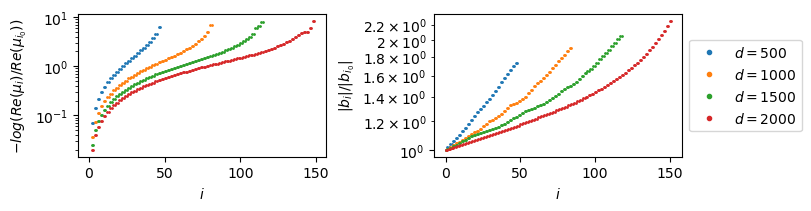

In [93]:
data=[np.concatenate([np.log(evs[i][:,np.newaxis])/dt,bss[i][::int(T/dt-1)].T],axis=1) for i in range(len(evs))]
data2=[np.concatenate([np.log(ev2s[i][:,np.newaxis])/dt,bs2s[i][::int(T/dt-1)].T],axis=1) for i in range(len(ev2s))]

plt.subplots(1,2,figsize=(8,2),layout='constrained')
plt.subplot(1,2,1)
for i in range(len(data)):
    vals=-np.sort(np.real(data[i][:,0]))[np.where(-np.sort(np.real(data[i][:,0]))<5)[0]]
    plt.plot(-np.log(vals/vals[0]),marker='o',lw=0,ms=1)
    plt.yscale('log')
    plt.ylabel('$-log(Re(\mu_i)/Re(\mu_{i_0}))$')
    plt.xlabel('$i$')
    # plt.gca().set_xticklabels('')
plt.subplot(1,2,2)
for i in range(len(data)):
    vals=-np.sort(np.abs(data[i][:,1]))[np.where(-np.sort(np.real(data[i][:,0]))<5)[0]]
    plt.plot(vals/vals[0],marker='o',lw=0,ms=1,label='$d=%i$'%ds[i])
    plt.yscale('log')
    plt.ylabel('$|b_i|/|b_{i_0}|$')
    plt.xlabel('$i$')
plt.gca().legend(loc='center left', markerscale=3, bbox_to_anchor=(1, 0.5))

plt.savefig('1ddmd3.pdf')
    

526 (-1.4144241333725497e-10+0j)
LinregressResult(slope=7.549964999652384e-11, intercept=-5.61258836083768, rvalue=0.8895354295021051, pvalue=0.0, stderr=1.868761471593271e-13, intercept_stderr=1.2410224559750427e-12)


/tmp/ipykernel_379260/4088844410.py:16: RuntimeWarning: invalid value encountered in power
  plt.plot(xs,np.exp(reg.intercept)*xs**reg.slope,c=colors[1])


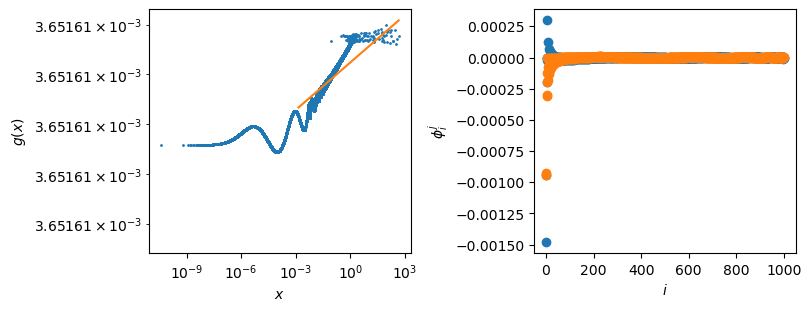

529 (-0.999983454846414+0j)
LinregressResult(slope=0.608665425656493, intercept=-5.276962373323245, rvalue=0.9558364058171323, pvalue=0.0, stderr=0.0009019380171983302, intercept_stderr=0.005989664011461111)


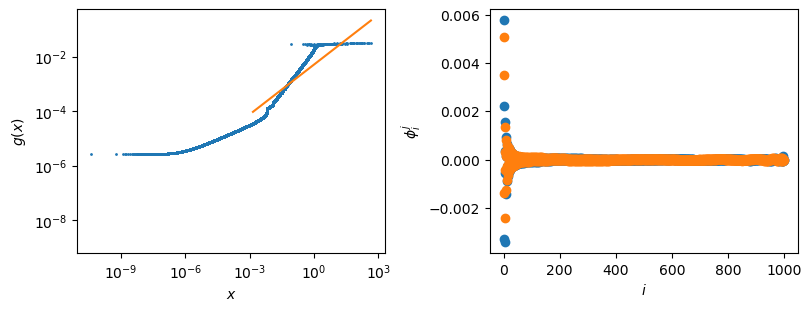

527 (-1.9906237221344625+0.18476848875045196j)
LinregressResult(slope=1.70087116063086, intercept=-5.011586883368759, rvalue=0.983416453899993, pvalue=0.0, stderr=0.0016786057450227, intercept_stderr=0.007469697410964848)


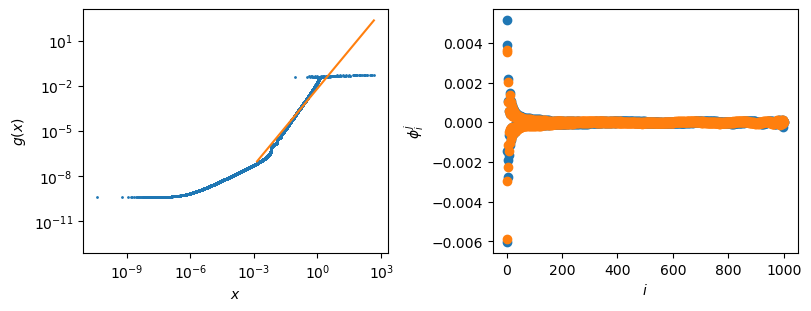

528 (-1.9906237221344625-0.18476848875045196j)
LinregressResult(slope=1.70087116063086, intercept=-5.011586883368759, rvalue=0.983416453899993, pvalue=0.0, stderr=0.0016786057450227, intercept_stderr=0.007469697410964848)


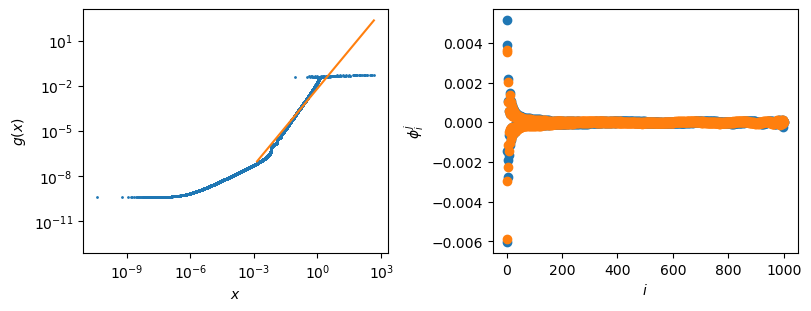

525 (-2.2337671297261057-0.8347229267148676j)
LinregressResult(slope=2.185050091726232, intercept=-4.4853826213932875, rvalue=0.9950181312857804, pvalue=0.0, stderr=0.0012461601540262601, intercept_stderr=0.004604924312473348)


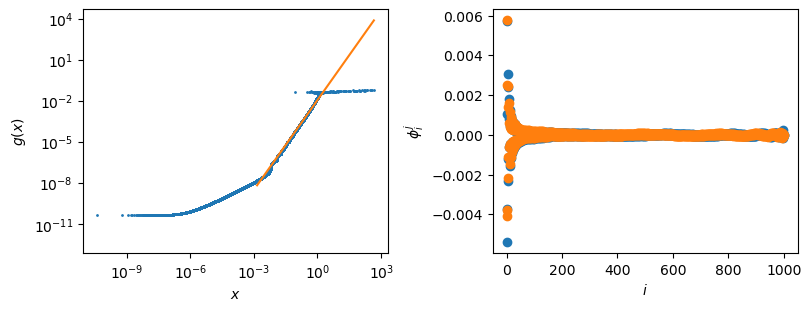

In [157]:
# The five leading Koopman mode in the exponential case; they approximate powers of x, as expected
for n in range(5):
    # i=np.argsort(res2)[n]
    i=np.argsort(-np.real(mus2))[n]
    print(i,mus2[i])
    v=np.concatenate([np.zeros(num//2+1),-2/np.arange(1,num//2+1)*(-1)**np.arange(1,num//2+1)])
    XX2=X_reconstruct2.dot(v)
    tinds=np.intersect1d(np.where(np.abs(bs2[:,i])>1E-8)[0],np.where(XX2>1E-8)[0])

    reg=linregress(np.log(XX2[tinds]),np.log(np.abs(bs2[tinds,i])))
    xs=np.min(XX2[:])+(np.max(XX2[:])-np.min(XX2[:]))*np.arange(10000)/10000
    print(reg)

    plt.subplots(1,2,figsize=(8,3),layout='constrained')
    plt.subplot(1,2,1)
    plt.plot(xs,np.exp(reg.intercept)*xs**reg.slope,c=colors[1])
    plt.scatter(XX2[:],np.abs(bs2[:,i]),s=1)
    # plt.scatter(X2[:,0],np.imag(bs2[:,i]),s=1)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$x$')
    plt.ylabel('$g(x)$')
    

    plt.subplot(1,2,2)
    # plt.plot(np.real(phis2[:1,i]),marker='o',lw=0)
    plt.plot(np.real(phis2[:num//2+1,i]),marker='o',lw=0)
    plt.plot(np.real(phis2[num//2+1:,i]),marker='o',lw=0)
    plt.xlabel('$i$')
    plt.ylabel('$\phi_i^j$')
    plt.show()

0 (0.11831903624861285-0.9738340080660199j)


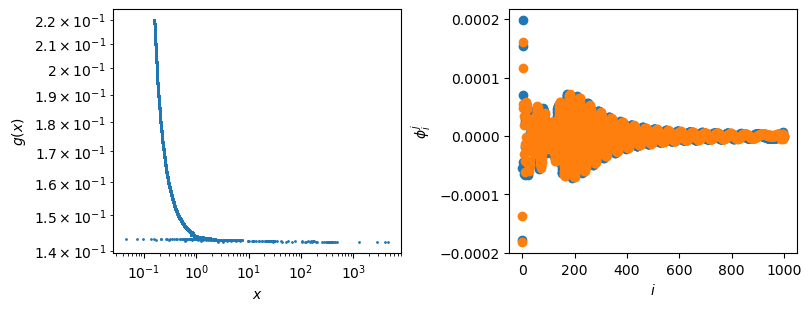

1 (0.11831903624861285+0.9738340080660199j)


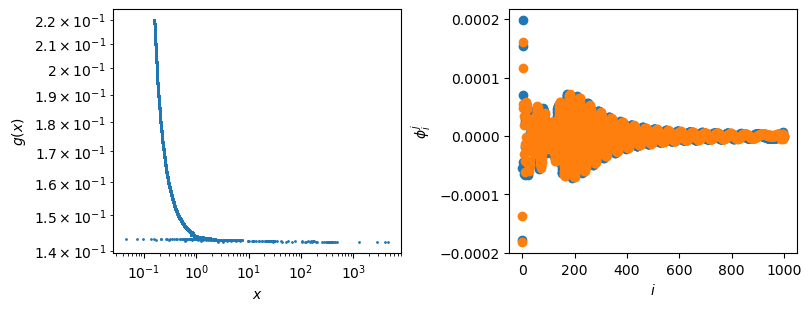

2 (0.029560508987854863+0j)


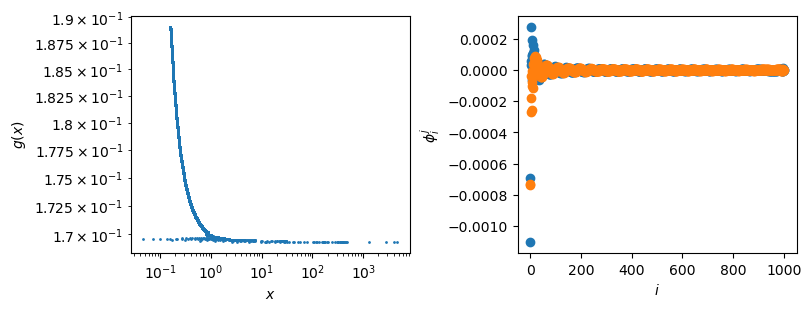

3 (0.028747453621039358-0.7862991896607594j)


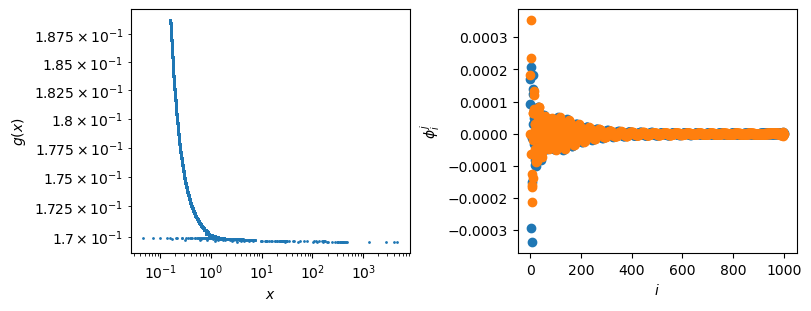

4 (0.028747453621039358+0.7862991896607594j)


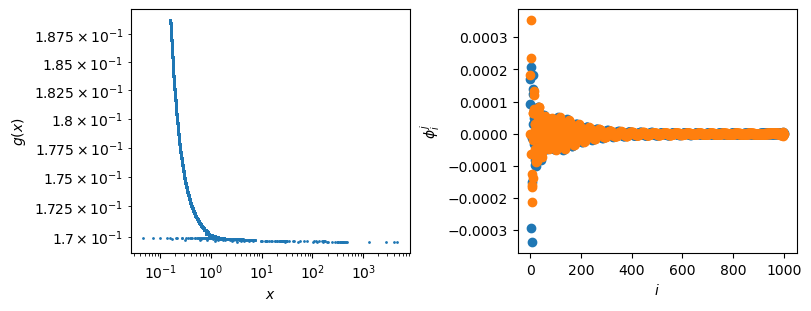

In [162]:
# The five leading Koopman mode in the algebraic case  
for n in range(5):
    # i=np.argsort(res)[n]
    i=np.argsort(-np.real(mus))[n]
    XX=X_reconstruct.dot(v)
    
    print(n,mus[i])
    plt.subplots(1,2,figsize=(8,3),layout='constrained')
    plt.subplot(1,2,1)
    plt.scatter(XX[:],-1/np.log(np.abs(bs[:,i])),s=1)
    # plt.scatter(X[:,0],np.imag(bs[:,i]),s=1)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$x$')
    plt.ylabel('$g(x)$')
    

    plt.subplot(1,2,2)
    # plt.plot(np.real(phis[:1,i]),marker='o',lw=0)
    plt.plot(np.real(phis[:num//2+1,i]),marker='o',lw=0)
    plt.plot(np.real(phis[num//2+1:,i]),marker='o',lw=0)
    plt.xlabel('$i$')
    plt.ylabel('$\phi_i^j$')
    plt.show()

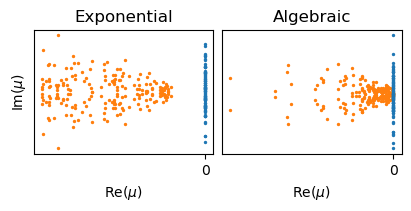

In [8]:
plt.subplots(1,2,figsize=(4,2),layout='constrained')

np.random.seed(1)
plt.subplot(1,2,1)
numosc=100
numdecay=100
yosc=np.random.normal(0,10,size=numosc)
xosc=np.zeros(numosc)

xdecay=np.random.uniform(-5,-1,size=numdecay)
ydecay=np.random.normal(0,5*(-1-xdecay)**0.5)
plt.scatter(xosc,yosc,s=2,c=colors[0])
plt.scatter(xdecay,ydecay,s=2,c=colors[1])
plt.scatter(xdecay,-ydecay,s=2,c=colors[1])
plt.xlabel('$\mathrm{Re}(\mu)$')
plt.ylabel('$\mathrm{Im}(\mu)$')
plt.gca().set_yticks([])
plt.gca().set_xticks([0])
plt.title('Exponential')


plt.subplot(1,2,2)
numosc=100
numdecay=100
yosc=np.random.normal(0,10,size=numosc)
xosc=np.zeros(numosc)

xdecay=-np.random.exponential(1,size=numdecay)
ydecay=np.random.normal(0,5*(-xdecay)**0.5)
plt.scatter(xosc,yosc,s=2,c=colors[0],zorder=5)
plt.scatter(xdecay,ydecay,s=2,c=colors[1],zorder=4)
plt.scatter(xdecay,-ydecay,s=2,c=colors[1],zorder=4)
plt.gca().set_yticks([])
plt.gca().set_xticks([0])
plt.title('Algebraic')
plt.xlabel('$\mathrm{Re}(\mu)$')
plt.savefig('schematic.pdf')
plt.show()